# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
student1 = "Guirec Maloisel"
student2 = "Adrian Valente"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
#np.random.seed(hash(student1 + student2) % 2**32)
#subset_of_classes = np.random.choice(range(10), 5, replace = False)
subset_of_classes = np.array([0,1,5,8,6])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
subset_of_classes

array([0, 1, 5, 8, 6])

### Plotting

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [4]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [5]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

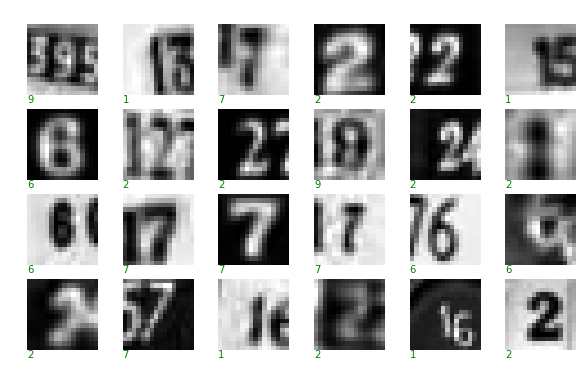

In [6]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [7]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Definition of some useful functions

In [8]:
def earlyStopping(history, min_delta=0, patience=0):
    """
    Returns the index at which we should have stopped to get the best loss
    """
    #nb_non_decrease = 0
    #delta = abs(min_delta)
    #n_epochs = len(history.history['loss'])
    #current_min = history.history['val_loss'][0]
    #for i in range(1, n_epochs):
    #    if(history.history['val_loss'][i] > current_min - delta):
    #        nb_non_decrease += 1
    #        if(nb_non_decrease > patience):
    #            return i - patience
    #    else:
    #        current_min = history.history['val_loss'][i]
    #        nb_non_decrease = 0
    #return i
    return np.nanargmin(history.history['val_loss'])

def scoreEarlyStopping(history, min_delta=0, patience=0):
    """
    Returns a tuple (val_loss, val_acc) that would have been obtained with early stopping
    """
    i = earlyStopping(history, min_delta, patience)
    return (history.history['val_loss'][i], history.history['val_acc'][i])

def plot_misclassified_samples(model, x_test, y_test):
    yhat_test = model.predict(x_test)
    error_indices = np.where(np.argmax(y_test, axis=1) != np.argmax(yhat_test, axis=1))[0]
    plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping=subset_of_classes)

In [9]:
import sys

standard_stdout = sys.stdout

def fit_model(model, x_train, y_train, **kwargs):
    file = open('logtrain.txt', 'w')
    sys.stdout = file
    history = model.fit(x_train, y_train, **kwargs)
    sys.stdout.flush()
    sys.stdout = standard_stdout
    return history

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 5)                 1285      
Total params: 1,285
Trainable params: 1,285
Non-trainable params: 0
_________________________________________________________________
(1.4906093940330616, 0.369768852348541)


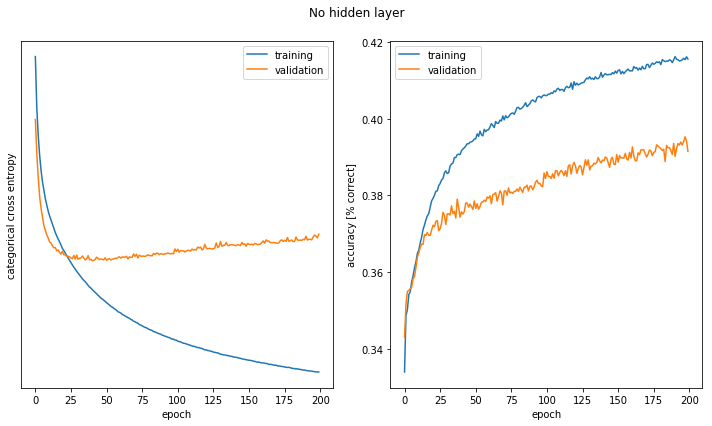

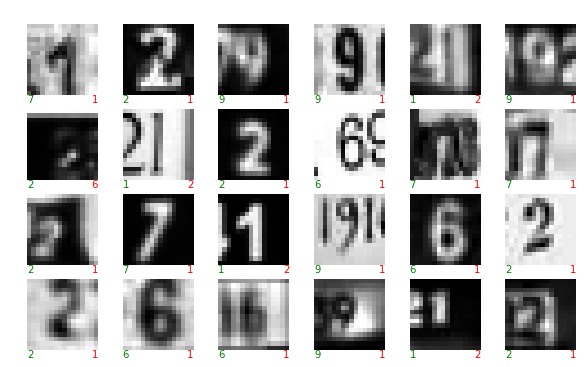

In [13]:
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(5, activation='softmax', input_shape=(256,)))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
model.summary()
es = EarlyStopping(monitor='val_loss', patience=5)
history = fit_model(model, x_train, y_train, 
          batch_size=128, epochs=200, validation_data=(x_test, y_test),  verbose=1)
score = scoreEarlyStopping(history)
print(score)
plot_history(history, "No hidden layer")
plot_misclassified_samples(model, x_test, y_test)

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

In [20]:
def build_model_ex2(optimizer, lr=None):
    model = Sequential()
    
    model.add(Dense(64, input_dim=256, activation='relu', name="H1"))
    model.add(Dense(5, activation='sigmoid', name = 'Y'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])
    model.summary()
    if lr is not None:
        model.optimizer.lr = lr
    
    return model

def test_model_ex2(optimizer, lr=None, title=""):
    model = build_model_ex2(optimizer, lr)
    history = fit_model(model, x_train, y_train, epochs=50, verbose=1, validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test)
    print("Validation Loss: ", score[0])
    print("Validation accuracy: ", score[1])
    plot_history(history, title=title)
    return history

### Tests with SGD

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
14839/14839 [==============================] - 0s 14us/step
Validation Loss:  1.4572739882308186
Validation accuracy:  0.34422804771210996


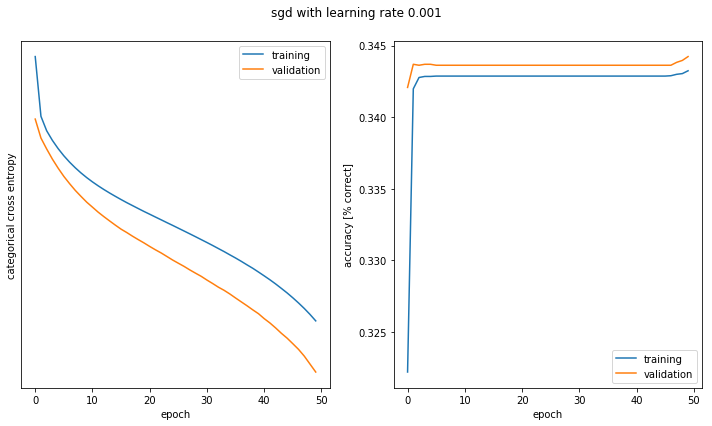

In [11]:
histories = []

lr = 0.001
optimizer = 'sgd'

histories.append(test_model_ex2(optimizer, lr, title=optimizer+" with learning rate "+str(lr)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
14839/14839 [==============================] - 0s 14us/step
Validation Loss:  0.621447727621401
Validation accuracy:  0.8183165981575311


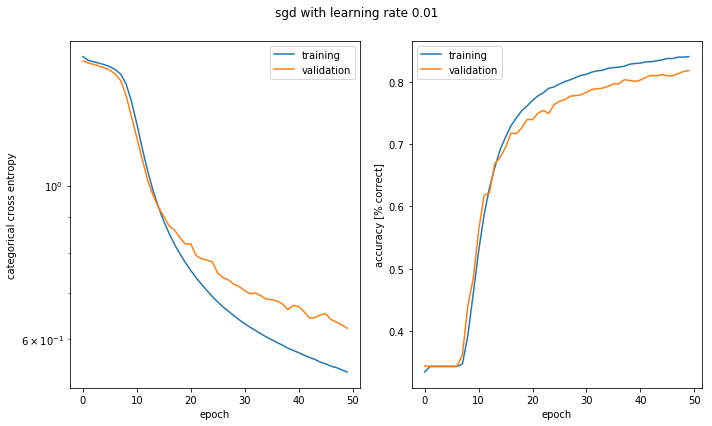

In [12]:
lr = 0.01
histories.append(test_model_ex2(optimizer, lr, title=optimizer+" with learning rate "+str(lr)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
14839/14839 [==============================] - 0s 14us/step
Validation Loss:  0.48101600376982373
Validation accuracy:  0.8710155670425466


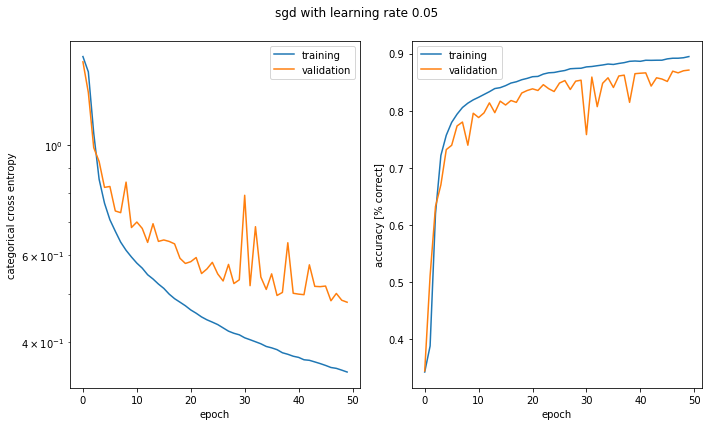

In [13]:
lr = 0.05
histories.append(test_model_ex2(optimizer, lr, title=optimizer+" with learning rate "+str(lr)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
14839/14839 [==============================] - 0s 14us/step
Validation Loss:  0.48595657574936857
Validation accuracy:  0.8707460070991542


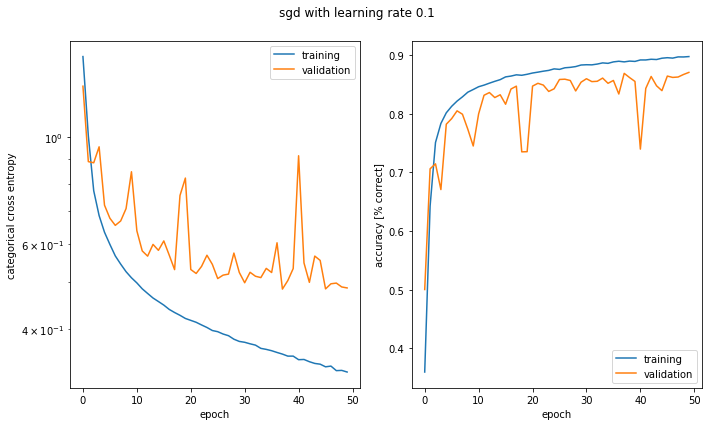

In [15]:
lr = 0.1
histories.append(test_model_ex2(optimizer, lr, title=optimizer+" with learning rate "+str(lr)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
14839/14839 [==============================] - 0s 15us/step
Validation Loss:  0.5436738602768355
Validation accuracy:  0.8619179189530527


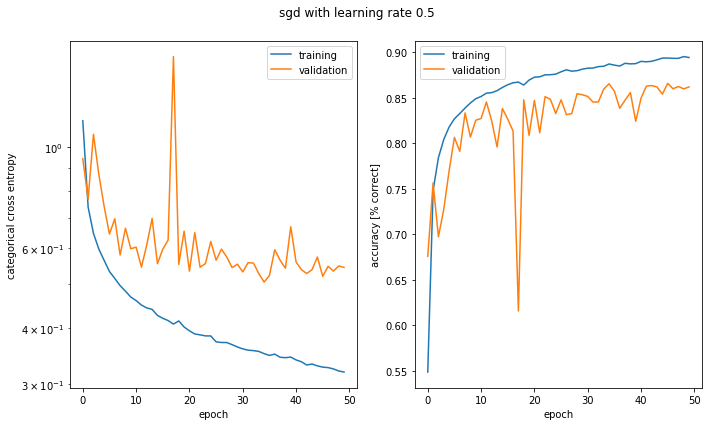

In [16]:
lr = 0.5
histories.append(test_model_ex2(optimizer, lr, title=optimizer+" with learning rate "+str(lr)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
14839/14839 [==============================] - 0s 15us/step
Validation Loss:  0.6739748262782264
Validation accuracy:  0.8336815148987645


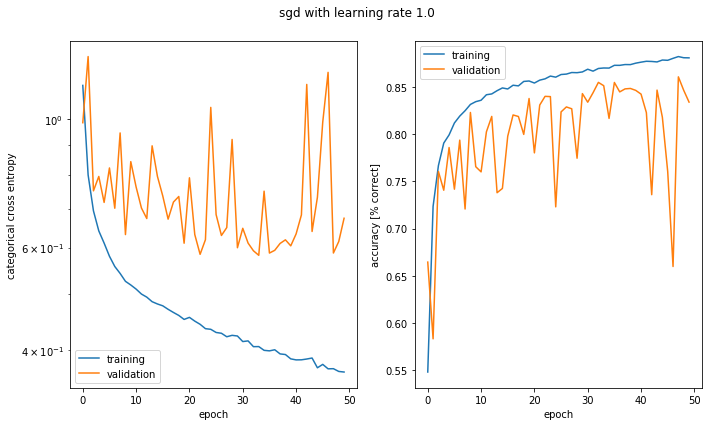

In [17]:
lr = 1.0
histories.append(test_model_ex2(optimizer, lr, title=optimizer+" with learning rate "+str(lr)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
14839/14839 [==============================] - 0s 15us/step
Validation Loss:  0.787434251990165
Validation accuracy:  0.8052429408547981


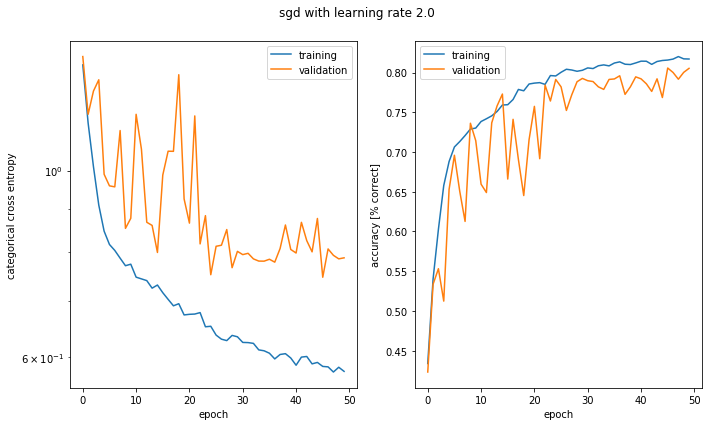

In [18]:
lr = 2.0
histories.append(test_model_ex2(optimizer, lr, title=optimizer+" with learning rate "+str(lr)))

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) Convergence is at first very fast, but then we oscillate around the optimum

B) Convergence is very slow

### Comparison of SGD and Adam

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 64)                16448     
_________________________________________________________________
Y (Dense)                    (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
14839/14839 [==============================] - 0s 14us/step
Validation Loss:  0.5067659236204031
Validation accuracy:  0.8724981468075232


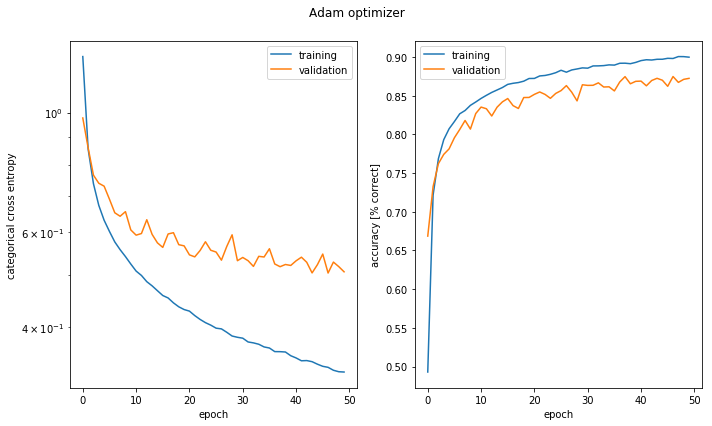

In [21]:
optimizer = 'adam'

histories.append(test_model_ex2(optimizer, title="Adam optimizer"))

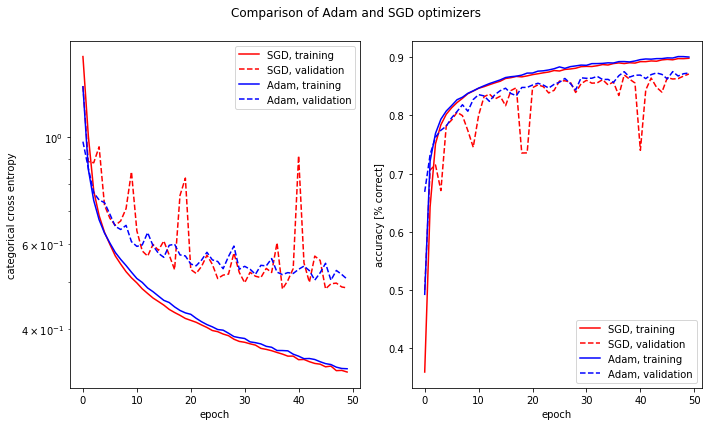

In [27]:
history_sgd = histories[3]
history_adam = histories[7]

fig, ax1, ax2 = prepare_standardplot("Comparison of Adam and SGD optimizers", 'epoch')
ax1.plot(history_sgd.history['loss'], label = "SGD, training", c='r')
ax1.plot(history_sgd.history['val_loss'], label = "SGD, validation", c='r', linestyle='--')
ax1.plot(history_adam.history['loss'], label = "Adam, training", c='b')
ax1.plot(history_adam.history['val_loss'], label = "Adam, validation", c='b', linestyle='--')
ax2.plot(history_sgd.history['acc'], label = "SGD, training", c='r')
ax2.plot(history_sgd.history['val_acc'], label = "SGD, validation", c='r', linestyle='--')
ax2.plot(history_adam.history['acc'], label = "Adam, training", c='b')
ax2.plot(history_adam.history['val_acc'], label = "Adam, validation", c='b', linestyle='--')
finalize_standardplot(fig, ax1, ax2)

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

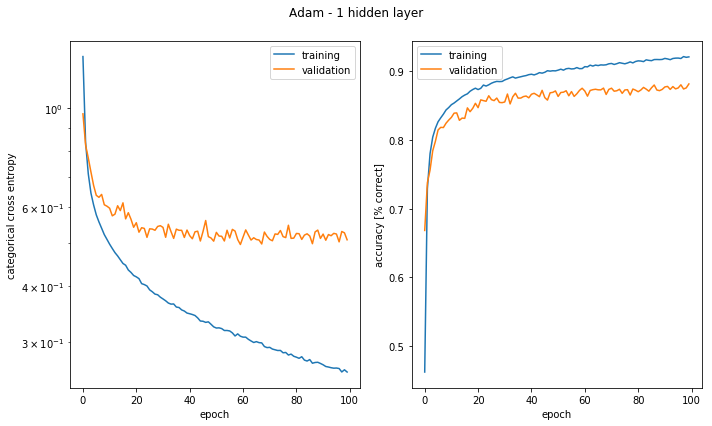

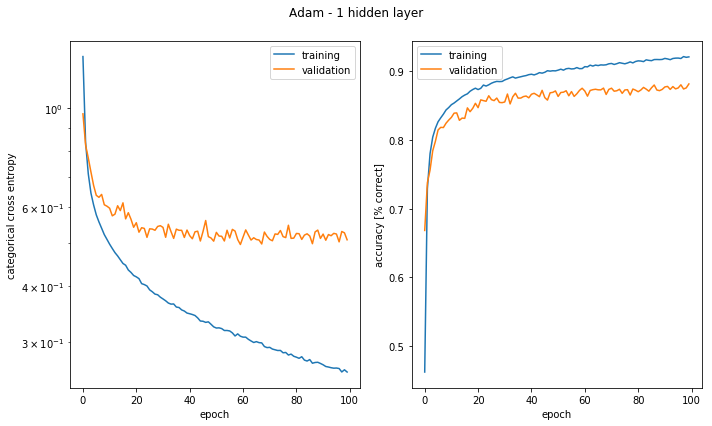

In [20]:
model = Sequential()

model.add(Dense(64, input_dim=256, activation='relu', name="H1"))
model.add(Dense(5, activation='sigmoid', name = 'Y'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.summary()
history = fit_model(model, x_train, y_train, epochs=100, verbose=1, validation_data = (x_test, y_test))
plot_history(history, title="Adam - 1 hidden layer")

In [21]:
score = scoreEarlyStopping(history)
print("Validation loss: ", score[0])
print("Accuracy loss: ", score[1])

Validation loss:  0.4959560508869096
Accuracy loss:  0.8751263561792809


**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: After 30-40 epochs, we can see overfitting, characterized by the divergence of the training and validation loss.

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: 

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

In [45]:
from keras.callbacks import TerminateOnNaN

def build_model_ex4(n_neurons):
    model = Sequential()
    model.add(Dense(n_neurons, input_dim=256, activation='relu', name="H1"))
    model.add(Dense(5, activation='sigmoid', name = 'Y'))
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

def test_model_ex4(n_neurons, repetitions):
    histories = []
    final_losses = []
    ES_losses = []
    final_accs = []
    ES_accs = []
    for i in range(repetitions):
        model = build_model_ex4(n_neurons)
        histories.append(fit_model(model, x_train, y_train, epochs=150, verbose=1, validation_data=(x_test, y_test),
                                  callbacks=[TerminateOnNaN()]))
        final_score = model.evaluate(x_test, y_test)
        if np.isnan(final_score[0]):
            lasti = np.where(np.isfinite(histories[-1].history['val_loss']))[0][-1]
            final_losses.append(histories[-1].history['val_loss'][lasti])
            final_accs.append(histories[-1].history['val_acc'][lasti])
        else:
            final_losses.append(final_score[0])
            final_accs.append(final_score[1])
        ES_score = scoreEarlyStopping(histories[-1])
        ES_losses.append(ES_score[0])
        ES_accs.append(ES_score[1])
    return final_losses, final_accs, ES_losses, ES_accs, histories

In [23]:
final_losses = []
ES_losses = []
final_accs = []
ES_accs = []
for n in (10, 100, 1000):
    fl, fa, el, ea, _ = test_model_ex4(n, 5)
    final_losses.append(fl)
    final_accs.append(fa)
    ES_losses.append(el)
    ES_accs.append(ea)

14839/14839 [==============================] - 0s 29us/step


KeyboardInterrupt: 

In [63]:
print(final_losses)
print(final_accs)
print(ES_losses)
print(ES_accs)

[[0.8161256946605752, 0.8221818927934818, 0.9146528591628633, 0.8691965701308676, 0.9362447488355351], [0.5670044316790144, 0.5994860798560333, 0.5769988906954697, 0.5985928771816397, 0.604492243913332], [0.8755659725580047, 0.8468480345741164, 0.9064097568152752, 0.9373765370043287, 0.8635606570517658]]
[[0.7767369768892516, 0.7686501785553452, 0.7189837589893101, 0.7397398746586431, 0.7257227576022377], [0.8862457038442179, 0.8839544444017007, 0.8866500437593064, 0.8862457038442179, 0.8797088752169518], [0.8861783138744368, 0.8868522137168507, 0.8718242468887909, 0.8766089359442575, 0.8813936249394728]]
[[0.8037604428147425, 0.8066753990221669, 0.9123233724165833, 0.8504813126343522, 0.9021571957926053], [0.4692232754603415, 0.49293876387968694, 0.47250207105618985, 0.48885194246591734, 0.48795879012499305], [0.4717211464367367, 0.47368538391719456, 0.47772836476711017, 0.4730383534582166, 0.47247674951769286]]
[[0.7798369162382643, 0.7710088280921629, 0.718916368987395, 0.7412224543

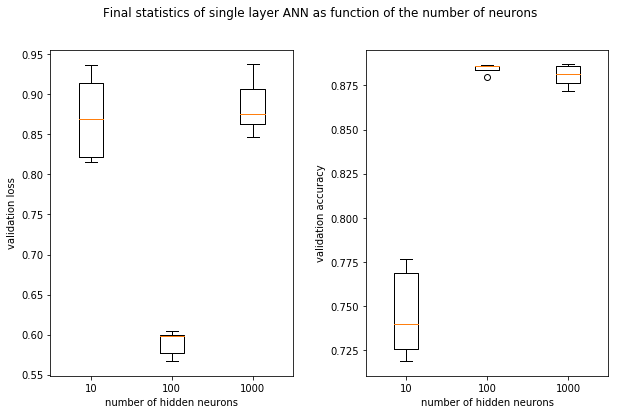

In [64]:
plt.figure()
ax = plt.subplot(121)
ax.boxplot(final_losses, labels=['10', '100', '1000'])
ax.set_xlabel("number of hidden neurons")
ax.set_ylabel("validation loss")
ax = plt.subplot(122)
ax.boxplot(final_accs, labels=['10', '100', '1000'])
ax.set_xlabel("number of hidden neurons")
ax.set_ylabel("validation accuracy")
plt.suptitle("Final statistics of single layer ANN as function of the number of neurons")
plt.subplots_adjust(wspace=0.3)
plt.show()

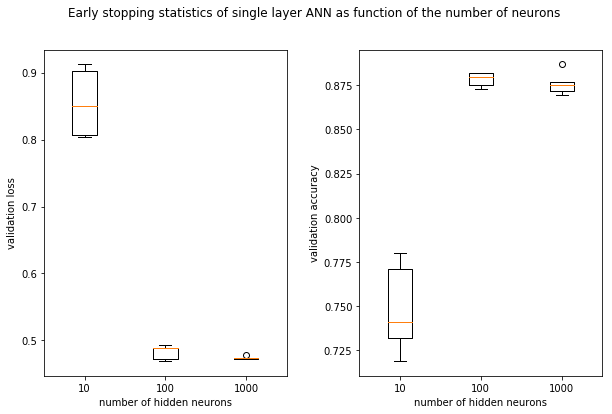

In [65]:
plt.figure()
ax = plt.subplot(121)
ax.boxplot(ES_losses, labels=['10', '100', '1000'])
ax.set_xlabel("number of hidden neurons")
ax.set_ylabel("validation loss")
ax = plt.subplot(122)
ax.boxplot(ES_accs, labels=['10', '100', '1000'])
ax.set_xlabel("number of hidden neurons")
ax.set_ylabel("validation accuracy")
plt.suptitle("Early stopping statistics of single layer ANN as function of the number of neurons")
plt.subplots_adjust(wspace=0.3)
plt.show()

One can notice on the previous figure that the best model is not the one with the most parameters, but the one with an intermediary number of parameters. This can be explained easily by looking at the training curves: the model with 10 hidden neurons

In [66]:
ES_accs_1 = ES_accs[1]
ES_losses_1 = ES_losses[1]

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

In [69]:
def nb_parameters(N_in, K, N_h, N_out):
    if K <= 0:
        return (N_in + 1) * N_out
    tot = (N_in + 1) * N_h
    tot += (K - 1) * (N_h + 1) * N_h
    tot += (N_h + 1) * N_out
    return tot

In [70]:
def ideal_N_h(N_in, K, N_h_1L, N_out):
    if K <= 0:
        return 0
    temp = N_in + K + N_out
    res = (-temp + np.sqrt(temp*temp + 4 * (K-1) * N_h_1L * (N_in + N_out + 1))) / (2 * (K - 1))
    return int(round(res))

In [72]:
def build_model_ex5(N_in, K, N_h, N_out):
    model = Sequential()
    if K <= 0:
        model.add(Dense(N_out, input_dim = N_in, activation='sigmoid', name = 'Y'))
    else:
        model.add(Dense(N_h, input_dim = N_in, activation = 'relu', name = 'H1'))
        for k in range(2, K + 1):
            model.add(Dense(N_h, activation='relu', name='H{}'.format(k)))
        model.add(Dense(N_out, activation='sigmoid', name='Y'))
    return model

In [80]:
def test_n_layers(K):
    N_in, N_h_1L, N_out = 256, 100, 5
    N_h = ideal_N_h(N_in, K, N_h_1L, N_out)
    histories = []
    for i in range(5):
        model = build_model_ex5(N_in, K, N_h, N_out)
        if (i==0):
            model.summary()
        model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
        histories.append(fit_model(model, x_train, y_train, epochs=100, verbose=1, validation_data=(x_test, y_test)))
    return histories

In [81]:
histories_2 = test_n_layers(2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 77)                19789     
_________________________________________________________________
H2 (Dense)                   (None, 77)                6006      
_________________________________________________________________
Y (Dense)                    (None, 5)                 390       
Total params: 26,185
Trainable params: 26,185
Non-trainable params: 0
_________________________________________________________________


In [82]:
histories_3 = test_n_layers(3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 66)                16962     
_________________________________________________________________
H2 (Dense)                   (None, 66)                4422      
_________________________________________________________________
H3 (Dense)                   (None, 66)                4422      
_________________________________________________________________
Y (Dense)                    (None, 5)                 335       
Total params: 26,141
Trainable params: 26,141
Non-trainable params: 0
_________________________________________________________________


In [83]:
histories_4 = test_n_layers(4)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
H1 (Dense)                   (None, 59)                15163     
_________________________________________________________________
H2 (Dense)                   (None, 59)                3540      
_________________________________________________________________
H3 (Dense)                   (None, 59)                3540      
_________________________________________________________________
H4 (Dense)                   (None, 59)                3540      
_________________________________________________________________
Y (Dense)                    (None, 5)                 300       
Total params: 26,083
Trainable params: 26,083
Non-trainable params: 0
_________________________________________________________________


In [84]:
losses, accuracies = [], []
losses_2, accuracies_2 = [], []
losses.append(ES_losses_1)
accuracies.append(ES_accs_1)
for histo in histories_2:
    score = scoreEarlyStopping(histo)
    losses_2.append(score[0])
    accuracies_2.append(score[1])
print(losses_2)
print(accuracies_2)
losses.append(losses_2)
accuracies.append(accuracies_2)

losses_3, accuracies_3 = [], []
for histo in histories_3:
    score = scoreEarlyStopping(histo)
    losses_3.append(score[0])
    accuracies_3.append(score[1])
print(losses_3)
print(accuracies_3)
losses.append(losses_3)
accuracies.append(accuracies_3)

losses_4, accuracies_4 = [], []
for histo in histories_4:
    score = scoreEarlyStopping(histo)
    losses_4.append(score[0])
    accuracies_4.append(score[1])
print(losses_4)
print(accuracies_4)
losses.append(losses_4)
accuracies.append(accuracies_4)

[0.4508071249004837, 0.45023934637426133, 0.46046521340075897, 0.4481768620424703, 0.4262851726150037]
[0.8658939281944091, 0.8724307567453568, 0.8656243681907654, 0.8696677673255845, 0.874587236308563]
[0.4265780736392813, 0.44233443640386877, 0.41514990450887795, 0.42053356728340724, 0.438398360262117]
[0.8742502864395739, 0.8619179189530527, 0.8740481164057112, 0.8693982073982591, 0.8666352179624199]
[0.4163505100675313, 0.4334343662660586, 0.43274815784357684, 0.42635056398348536, 0.4217004397943886]
[0.8727003167650675, 0.8675786777642933, 0.8704090571699137, 0.8781589055585125, 0.8693982074585105]


In [9]:
losses = []
accuracies = []
losses.append([0.4742917674588293, 0.4840815785165922, 0.48891783804575045, 0.4825939503518773, 0.4766730998306151])
accuracies.append([0.8879304534904204, 0.8882000134940642, 0.8855044140320227, 0.8869869937648653, 0.8898173730941673])
losses.append([0.44038299532445646, 0.45191934383239246, 0.42974044780331455, 0.459877050801006, 0.4406830834140594])
accuracies.append([0.8791023654206374, 0.8791023654206374, 0.882404474650876, 0.8811240649960804, 0.8794393152735595])
losses.append([0.44857124835543977, 0.41786009866968465, 0.43225778449826086, 0.4231242689894203, 0.4314301604690863])
accuracies.append([0.8751263561792809, 0.8786980255055487, 0.8805175551234474, 0.8828762046281311, 0.8797088752932702])
losses.append([0.41713447983201135, 0.40979840753012425, 0.4224874339131655, 0.4215794332615167, 0.43145339571647995])
accuracies.append([0.8763393760008651, 0.880854505052688, 0.8749915762075847, 0.8795067052594076, 0.8749915762075847])

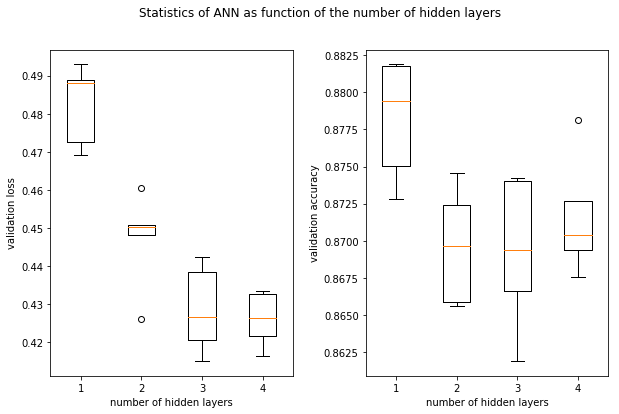

In [85]:
plt.figure()
ax = plt.subplot(121)
ax.boxplot(losses, labels=['1', '2', '3', '4'])
ax.set_xlabel("number of hidden layers")
ax.set_ylabel("validation loss")
ax = plt.subplot(122)
ax.boxplot(accuracies, labels=['1', '2', '3', '4'])
ax.set_xlabel("number of hidden layers")
ax.set_ylabel("validation accuracy")
plt.suptitle("Statistics of ANN as function of the number of hidden layers")
plt.subplots_adjust(wspace=0.3)
plt.show()

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

#### 1 hidden layer

In [14]:
model1_simple = Sequential()
model1_simple.add(Dense(100, activation='relu', input_shape=(256,)))
model1_simple.add(Dense(5, activation='softmax'))
model1_simple.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history_model1_simple = model1_simple.fit(x_train, y_train, epochs=50, verbose=1, validation_data=(x_test, y_test))
print(model1_simple.evaluate(x_test, y_test))

Train on 40427 samples, validate on 14839 samples
Epoch 1/50
40427/40427 [==============================] - 12s 291us/step - loss: 1.1614 - acc: 0.5627 - val_loss: 0.9144 - val_acc: 0.7001
Epoch 2/50
40427/40427 [==============================] - 12s 306us/step - loss: 0.7688 - acc: 0.7589 - val_loss: 0.7640 - val_acc: 0.7654
Epoch 3/50
40427/40427 [==============================] - 9s 229us/step - loss: 0.6642 - acc: 0.7974 - val_loss: 0.6830 - val_acc: 0.7926
Epoch 4/50
40427/40427 [==============================] - 14s 336us/step - loss: 0.6089 - acc: 0.8146 - val_loss: 0.6617 - val_acc: 0.8022
Epoch 5/50
40427/40427 [==============================] - 11s 283us/step - loss: 0.5679 - acc: 0.8284 - val_loss: 0.6253 - val_acc: 0.8135
Epoch 6/50
40427/40427 [==============================] - 9s 211us/step - loss: 0.5380 - acc: 0.8365 - val_loss: 0.6497 - val_acc: 0.8051
Epoch 7/50
40427/40427 [==============================] - 9s 226us/step - loss: 0.5122 - acc: 0.8473 - val_loss: 0.585

Train on 40427 samples, validate on 14839 samples
Epoch 1/200
40427/40427 [==============================] - 12s 290us/step - loss: 1.2429 - acc: 0.5158 - val_loss: 0.9636 - val_acc: 0.6788
Epoch 2/200
40427/40427 [==============================] - 10s 247us/step - loss: 0.9383 - acc: 0.6751 - val_loss: 0.7908 - val_acc: 0.7488
Epoch 3/200
40427/40427 [==============================] - 7s 174us/step - loss: 0.8553 - acc: 0.7088 - val_loss: 0.7461 - val_acc: 0.7587
Epoch 4/200
40427/40427 [==============================] - 7s 168us/step - loss: 0.8127 - acc: 0.7229 - val_loss: 0.7054 - val_acc: 0.7767
Epoch 5/200
40427/40427 [==============================] - 7s 169us/step - loss: 0.7882 - acc: 0.7295 - val_loss: 0.6940 - val_acc: 0.7782
Epoch 6/200
40427/40427 [==============================] - 7s 169us/step - loss: 0.7680 - acc: 0.7372 - val_loss: 0.6579 - val_acc: 0.7875
Epoch 7/200
40427/40427 [==============================] - 7s 168us/step - loss: 0.7526 - acc: 0.7412 - val_loss: 

40427/40427 [==============================] - 5s 133us/step - loss: 0.5800 - acc: 0.8027 - val_loss: 0.5310 - val_acc: 0.8405
Epoch 116/200
40427/40427 [==============================] - 5s 134us/step - loss: 0.5776 - acc: 0.8007 - val_loss: 0.5250 - val_acc: 0.8448
Epoch 117/200
40427/40427 [==============================] - 5s 132us/step - loss: 0.5770 - acc: 0.8005 - val_loss: 0.5286 - val_acc: 0.8480
Epoch 118/200
40427/40427 [==============================] - 6s 136us/step - loss: 0.5788 - acc: 0.7994 - val_loss: 0.5350 - val_acc: 0.8364
Epoch 119/200
40427/40427 [==============================] - 5s 133us/step - loss: 0.5751 - acc: 0.8015 - val_loss: 0.5240 - val_acc: 0.8410
Epoch 120/200
40427/40427 [==============================] - 5s 133us/step - loss: 0.5801 - acc: 0.8002 - val_loss: 0.5222 - val_acc: 0.8361
Epoch 121/200
40427/40427 [==============================] - 5s 134us/step - loss: 0.5769 - acc: 0.8022 - val_loss: 0.5192 - val_acc: 0.8480
Epoch 122/200
40427/40427 [

Epoch 172/200
40427/40427 [==============================] - 5s 131us/step - loss: 0.5707 - acc: 0.8035 - val_loss: 0.5210 - val_acc: 0.8422
Epoch 173/200
40427/40427 [==============================] - 5s 134us/step - loss: 0.5722 - acc: 0.8030 - val_loss: 0.5162 - val_acc: 0.8473
Epoch 174/200
40427/40427 [==============================] - 5s 134us/step - loss: 0.5744 - acc: 0.8023 - val_loss: 0.5011 - val_acc: 0.8571s - loss: 0.
Epoch 175/200
40427/40427 [==============================] - 5s 133us/step - loss: 0.5710 - acc: 0.8021 - val_loss: 0.5096 - val_acc: 0.8517
Epoch 176/200
40427/40427 [==============================] - 5s 134us/step - loss: 0.5662 - acc: 0.8050 - val_loss: 0.5195 - val_acc: 0.8478
Epoch 177/200
40427/40427 [==============================] - 5s 135us/step - loss: 0.5669 - acc: 0.8055 - val_loss: 0.5148 - val_acc: 0.8486
Epoch 178/200
40427/40427 [==============================] - 5s 133us/step - loss: 0.5738 - acc: 0.8026 - val_loss: 0.5021 - val_acc: 0.8534
E

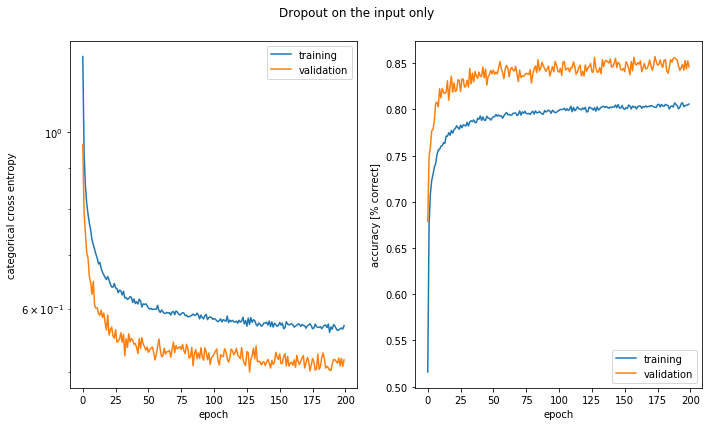

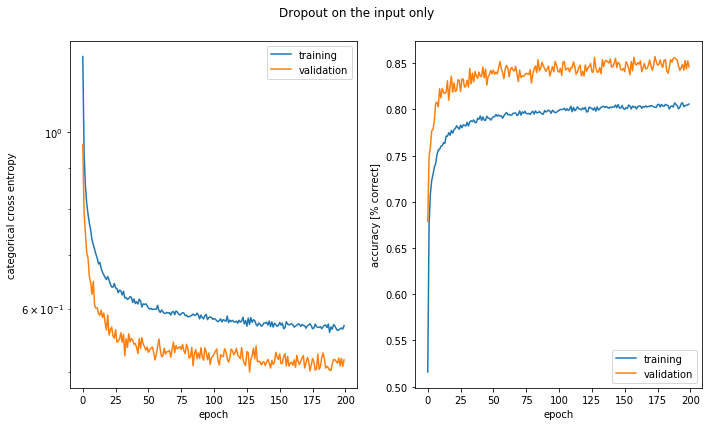

In [25]:
# Dropout on the input only
model1_dropout1 = Sequential()
model1_dropout1.add(Dropout(0.2, input_shape=(256,)))
model1_dropout1.add(Dense(100, activation='relu'))
model1_dropout1.add(Dense(5, activation='softmax'))
model1_dropout1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history_model1_dropout1 = model1_dropout1.fit(x_train, y_train, epochs=200, verbose=1, validation_data=(x_test, y_test))
print(model1_dropout1.evaluate(x_test, y_test))
plot_history(history_model1_dropout1, title="Dropout on the input only")

Train on 40427 samples, validate on 14839 samples
Epoch 1/200
40427/40427 [==============================] - 7s 172us/step - loss: 1.1825 - acc: 0.5523 - val_loss: 0.8945 - val_acc: 0.7054
Epoch 2/200
40427/40427 [==============================] - 5s 136us/step - loss: 0.8191 - acc: 0.7321 - val_loss: 0.7656 - val_acc: 0.7593
Epoch 3/200
40427/40427 [==============================] - 5s 134us/step - loss: 0.7168 - acc: 0.7714 - val_loss: 0.7239 - val_acc: 0.7807
Epoch 4/200
40427/40427 [==============================] - 6s 138us/step - loss: 0.6648 - acc: 0.7899 - val_loss: 0.6633 - val_acc: 0.7984
Epoch 5/200
40427/40427 [==============================] - 5s 136us/step - loss: 0.6323 - acc: 0.8003 - val_loss: 0.6488 - val_acc: 0.8026
Epoch 6/200
40427/40427 [==============================] - 5s 134us/step - loss: 0.6065 - acc: 0.8101 - val_loss: 0.6663 - val_acc: 0.7974
Epoch 7/200
40427/40427 [==============================] - 5s 135us/step - loss: 0.5926 - acc: 0.8141 - val_loss: 0.

40427/40427 [==============================] - 6s 136us/step - loss: 0.3947 - acc: 0.8755 - val_loss: 0.5225 - val_acc: 0.8680930 - 
Epoch 60/200
40427/40427 [==============================] - 5s 135us/step - loss: 0.3936 - acc: 0.8771 - val_loss: 0.5027 - val_acc: 0.8716
Epoch 61/200
40427/40427 [==============================] - 5s 135us/step - loss: 0.3817 - acc: 0.8814 - val_loss: 0.4875 - val_acc: 0.8794
Epoch 62/200
40427/40427 [==============================] - 5s 136us/step - loss: 0.3889 - acc: 0.8796 - val_loss: 0.4936 - val_acc: 0.8763
Epoch 63/200
40427/40427 [==============================] - 5s 136us/step - loss: 0.3905 - acc: 0.8782 - val_loss: 0.4992 - val_acc: 0.8754
Epoch 64/200
40427/40427 [==============================] - 6s 136us/step - loss: 0.3856 - acc: 0.8799 - val_loss: 0.5020 - val_acc: 0.8732
Epoch 65/200
40427/40427 [==============================] - 5s 135us/step - loss: 0.3859 - acc: 0.8802 - val_loss: 0.4911 - val_acc: 0.8745
Epoch 66/200
40427/40427 [=

40427/40427 [==============================] - 6s 141us/step - loss: 0.3243 - acc: 0.8993 - val_loss: 0.5075 - val_acc: 0.8843
Epoch 175/200
40427/40427 [==============================] - 5s 135us/step - loss: 0.3255 - acc: 0.8997 - val_loss: 0.5006 - val_acc: 0.8858
Epoch 176/200
40427/40427 [==============================] - 5s 135us/step - loss: 0.3229 - acc: 0.8989 - val_loss: 0.5005 - val_acc: 0.8864
Epoch 177/200
40427/40427 [==============================] - 5s 136us/step - loss: 0.3272 - acc: 0.8987 - val_loss: 0.5006 - val_acc: 0.8880
Epoch 178/200
40427/40427 [==============================] - 5s 134us/step - loss: 0.3189 - acc: 0.8997 - val_loss: 0.5212 - val_acc: 0.8830
Epoch 179/200
40427/40427 [==============================] - 5s 135us/step - loss: 0.3221 - acc: 0.8988 - val_loss: 0.5134 - val_acc: 0.8842
Epoch 180/200
40427/40427 [==============================] - 5s 136us/step - loss: 0.3228 - acc: 0.8999 - val_loss: 0.5071 - val_acc: 0.8851
Epoch 181/200
40427/40427 [

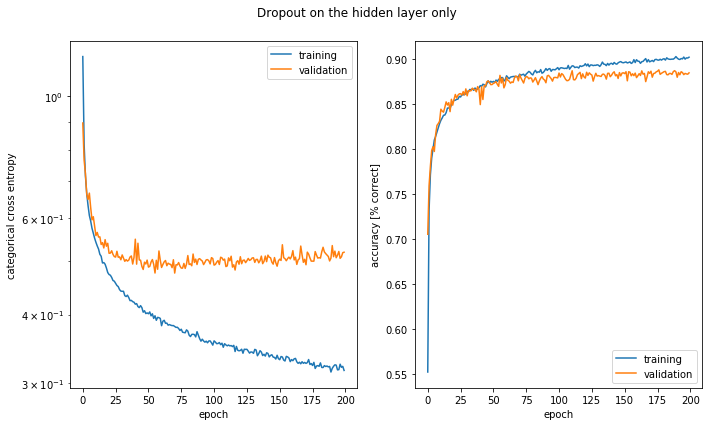

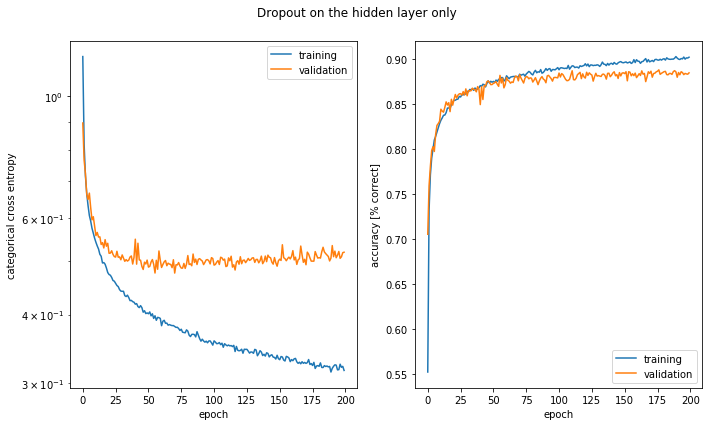

In [26]:
# Dropout on the hidden layer only
model1_dropout2 = Sequential()
model1_dropout2.add(Dense(100, activation='relu', input_shape=(256,)))
model1_dropout2.add(Dropout(0.2))
model1_dropout2.add(Dense(5, activation='softmax'))
model1_dropout2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history_model1_dropout2 = model1_dropout2.fit(x_train, y_train, epochs=200, verbose=1, validation_data=(x_test, y_test))
print(model1_dropout2.evaluate(x_test, y_test))
plot_history(history_model1_dropout2, title="Dropout on the hidden layer only")

Train on 40427 samples, validate on 14839 samples
Epoch 1/200
40427/40427 [==============================] - 9s 225us/step - loss: 1.2598 - acc: 0.5057 - val_loss: 0.9141 - val_acc: 0.6845
Epoch 2/200
40427/40427 [==============================] - 7s 171us/step - loss: 0.9447 - acc: 0.6674 - val_loss: 0.7817 - val_acc: 0.7486
Epoch 3/200
40427/40427 [==============================] - 7s 174us/step - loss: 0.8748 - acc: 0.6946 - val_loss: 0.7407 - val_acc: 0.7783
Epoch 4/200
40427/40427 [==============================] - 7s 170us/step - loss: 0.8405 - acc: 0.7100 - val_loss: 0.7139 - val_acc: 0.7860
Epoch 5/200
40427/40427 [==============================] - 7s 170us/step - loss: 0.8158 - acc: 0.7166 - val_loss: 0.6974 - val_acc: 0.7777
Epoch 6/200
40427/40427 [==============================] - 7s 173us/step - loss: 0.8010 - acc: 0.7234 - val_loss: 0.6828 - val_acc: 0.7837
Epoch 7/200
40427/40427 [==============================] - 7s 173us/step - loss: 0.7788 - acc: 0.7296 - val_loss: 0.

40427/40427 [==============================] - 7s 170us/step - loss: 0.6219 - acc: 0.7850 - val_loss: 0.5377 - val_acc: 0.8423
Epoch 118/200
40427/40427 [==============================] - 7s 170us/step - loss: 0.6264 - acc: 0.7822 - val_loss: 0.5428 - val_acc: 0.8451
Epoch 119/200
40427/40427 [==============================] - 7s 169us/step - loss: 0.6248 - acc: 0.7832 - val_loss: 0.5650 - val_acc: 0.8222
Epoch 120/200
40427/40427 [==============================] - 7s 172us/step - loss: 0.6268 - acc: 0.7821 - val_loss: 0.5404 - val_acc: 0.8443
Epoch 121/200
40427/40427 [==============================] - 7s 171us/step - loss: 0.6217 - acc: 0.7864 - val_loss: 0.5531 - val_acc: 0.8389
Epoch 122/200
40427/40427 [==============================] - 7s 170us/step - loss: 0.6288 - acc: 0.7829 - val_loss: 0.5628 - val_acc: 0.8318
Epoch 123/200
40427/40427 [==============================] - 7s 169us/step - loss: 0.6274 - acc: 0.7830 - val_loss: 0.5421 - val_acc: 0.8394
Epoch 124/200
40427/40427 [

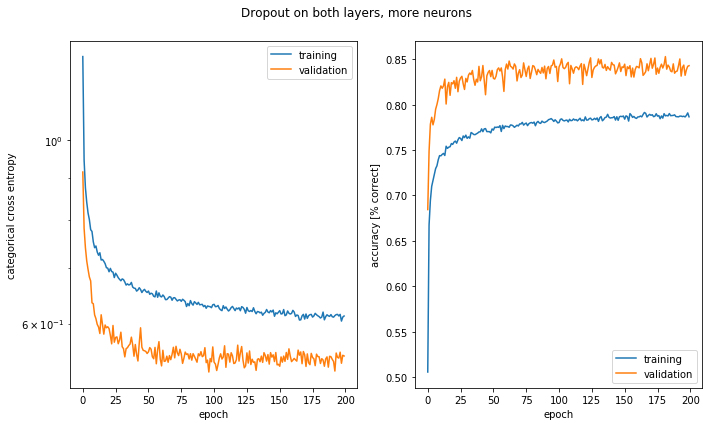

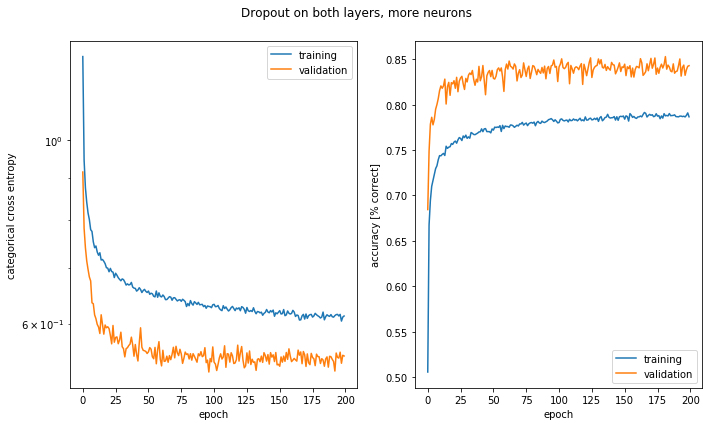

In [27]:
# Dropout on both layers, more neurons
model1_dropout3 = Sequential()
model1_dropout3.add(Dropout(0.2, input_shape=(256,)))
model1_dropout3.add(Dense(200, activation='relu'))
model1_dropout3.add(Dropout(0.2))
model1_dropout3.add(Dense(5, activation='softmax'))
model1_dropout3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history_model1_dropout3 = model1_dropout3.fit(x_train, y_train, epochs=200, verbose=1, validation_data=(x_test, y_test))
print(model1_dropout3.evaluate(x_test, y_test))
plot_history(history_model1_dropout3, title="Dropout on both layers, more neurons")

Train on 40427 samples, validate on 14839 samples
Epoch 1/200
40427/40427 [==============================] - 10s 254us/step - loss: 1.2693 - acc: 0.5039 - val_loss: 0.9359 - val_acc: 0.6875
Epoch 2/200
40427/40427 [==============================] - 8s 203us/step - loss: 1.0136 - acc: 0.6233 - val_loss: 0.8361 - val_acc: 0.7353
Epoch 3/200
40427/40427 [==============================] - 8s 201us/step - loss: 0.9603 - acc: 0.6477 - val_loss: 0.7869 - val_acc: 0.7244
Epoch 4/200
40427/40427 [==============================] - 8s 199us/step - loss: 0.9404 - acc: 0.6534 - val_loss: 0.7647 - val_acc: 0.7513
Epoch 5/200
40427/40427 [==============================] - 8s 202us/step - loss: 0.9156 - acc: 0.6662 - val_loss: 0.7732 - val_acc: 0.7366
Epoch 6/200
40427/40427 [==============================] - 8s 210us/step - loss: 0.8986 - acc: 0.6705 - val_loss: 0.7236 - val_acc: 0.7715
Epoch 7/200
40427/40427 [==============================] - 8s 201us/step - loss: 0.8871 - acc: 0.6777 - val_loss: 0

40427/40427 [==============================] - 8s 203us/step - loss: 0.7381 - acc: 0.7369 - val_loss: 0.5920 - val_acc: 0.8238
Epoch 118/200
40427/40427 [==============================] - 8s 201us/step - loss: 0.7355 - acc: 0.7375 - val_loss: 0.5906 - val_acc: 0.8191
Epoch 119/200
40427/40427 [==============================] - 8s 200us/step - loss: 0.7346 - acc: 0.7370 - val_loss: 0.6009 - val_acc: 0.8164
Epoch 120/200
40427/40427 [==============================] - 8s 203us/step - loss: 0.7374 - acc: 0.7382 - val_loss: 0.5896 - val_acc: 0.8228
Epoch 121/200
40427/40427 [==============================] - 8s 201us/step - loss: 0.7359 - acc: 0.7360 - val_loss: 0.5906 - val_acc: 0.8173
Epoch 122/200
40427/40427 [==============================] - 8s 208us/step - loss: 0.7338 - acc: 0.7391 - val_loss: 0.5772 - val_acc: 0.8185
Epoch 123/200
40427/40427 [==============================] - 8s 204us/step - loss: 0.7362 - acc: 0.7382 - val_loss: 0.5906 - val_acc: 0.8194
Epoch 124/200
40427/40427 [

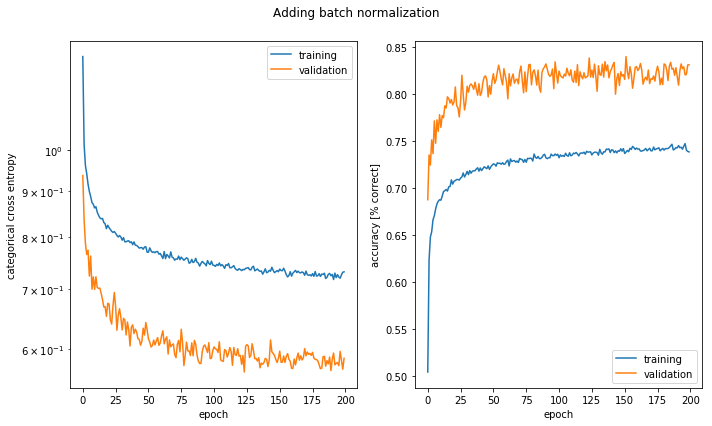

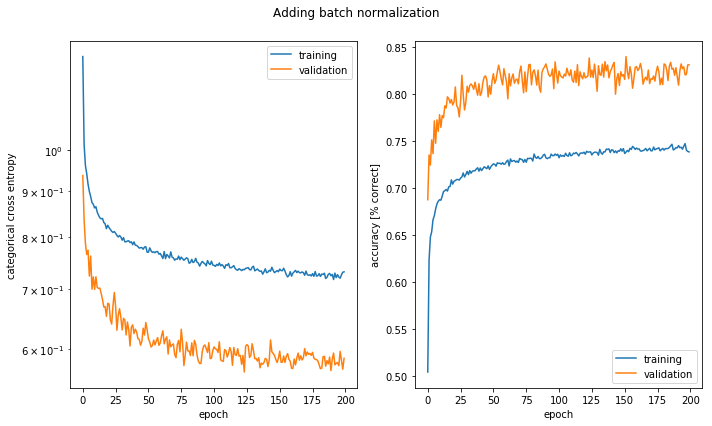

In [28]:
from keras.layers import BatchNormalization
# Adding batch normalization
model1_dropoutBN = Sequential()
model1_dropoutBN.add(Dropout(0.2, input_shape=(256,)))
model1_dropoutBN.add(Dense(200, activation='relu'))
model1_dropoutBN.add(BatchNormalization())
model1_dropoutBN.add(Dropout(0.2))
model1_dropoutBN.add(Dense(5, activation='softmax'))
model1_dropoutBN.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history_model1_dropoutBN = model1_dropoutBN.fit(x_train, y_train, epochs=200, verbose=1, validation_data=(x_test, y_test))
print(model1_dropoutBN.evaluate(x_test, y_test))
plot_history(history_model1_dropoutBN, title="Adding batch normalization")

Train on 40427 samples, validate on 14839 samples
Epoch 1/200
40427/40427 [==============================] - 11s 277us/step - loss: 1.5478 - acc: 0.4727 - val_loss: 1.2617 - val_acc: 0.5862
Epoch 2/200
40427/40427 [==============================] - 9s 234us/step - loss: 1.2306 - acc: 0.5922 - val_loss: 1.1720 - val_acc: 0.6119
Epoch 3/200
40427/40427 [==============================] - 10s 235us/step - loss: 1.1501 - acc: 0.6438 - val_loss: 1.1157 - val_acc: 0.6486
Epoch 4/200
40427/40427 [==============================] - 13s 322us/step - loss: 1.0956 - acc: 0.6734 - val_loss: 1.0659 - val_acc: 0.7263
Epoch 5/200
40427/40427 [==============================] - 25s 624us/step - loss: 1.0575 - acc: 0.6899 - val_loss: 1.0196 - val_acc: 0.6983
Epoch 6/200
40427/40427 [==============================] - 22s 551us/step - loss: 1.0314 - acc: 0.7032 - val_loss: 1.0039 - val_acc: 0.7261
Epoch 7/200
40427/40427 [==============================] - 24s 596us/step - loss: 1.0124 - acc: 0.7077 - val_lo

Epoch 59/200
40427/40427 [==============================] - 10s 238us/step - loss: 0.9193 - acc: 0.7259 - val_loss: 0.8988 - val_acc: 0.7428
Epoch 60/200
40427/40427 [==============================] - 9s 229us/step - loss: 0.9220 - acc: 0.7262 - val_loss: 0.9108 - val_acc: 0.7547
Epoch 61/200
40427/40427 [==============================] - 9s 225us/step - loss: 0.9143 - acc: 0.7301 - val_loss: 0.8838 - val_acc: 0.7582
Epoch 62/200
40427/40427 [==============================] - 9s 221us/step - loss: 0.9101 - acc: 0.7306 - val_loss: 0.9104 - val_acc: 0.7424
Epoch 63/200
40427/40427 [==============================] - 9s 228us/step - loss: 0.9104 - acc: 0.7334 - val_loss: 0.8670 - val_acc: 0.7601
Epoch 64/200
40427/40427 [==============================] - 9s 222us/step - loss: 0.9089 - acc: 0.7301 - val_loss: 0.9500 - val_acc: 0.7308
Epoch 65/200
40427/40427 [==============================] - 9s 226us/step - loss: 0.9173 - acc: 0.7292 - val_loss: 0.8702 - val_acc: 0.7627
Epoch 66/200
40427/

40427/40427 [==============================] - 7s 165us/step - loss: 0.9228 - acc: 0.7202 - val_loss: 0.9078 - val_acc: 0.7226
Epoch 175/200
40427/40427 [==============================] - 7s 167us/step - loss: 0.9201 - acc: 0.7219 - val_loss: 0.8588 - val_acc: 0.7530
Epoch 176/200
40427/40427 [==============================] - 7s 166us/step - loss: 0.9164 - acc: 0.7237 - val_loss: 0.8930 - val_acc: 0.7525
Epoch 177/200
40427/40427 [==============================] - 7s 166us/step - loss: 0.9178 - acc: 0.7236 - val_loss: 0.8449 - val_acc: 0.7698
Epoch 178/200
40427/40427 [==============================] - 7s 168us/step - loss: 0.9302 - acc: 0.7158 - val_loss: 0.8872 - val_acc: 0.7544
Epoch 179/200
40427/40427 [==============================] - 7s 165us/step - loss: 0.9348 - acc: 0.7148 - val_loss: 0.8922 - val_acc: 0.7649
Epoch 180/200
40427/40427 [==============================] - 7s 171us/step - loss: 0.9343 - acc: 0.7132 - val_loss: 0.8848 - val_acc: 0.7441
Epoch 181/200
40427/40427 [

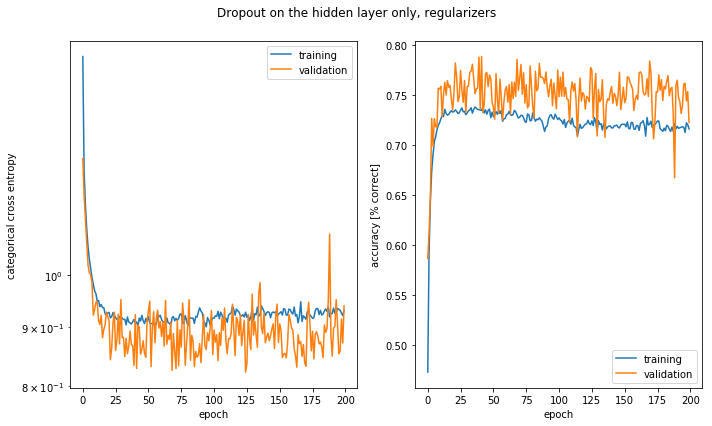

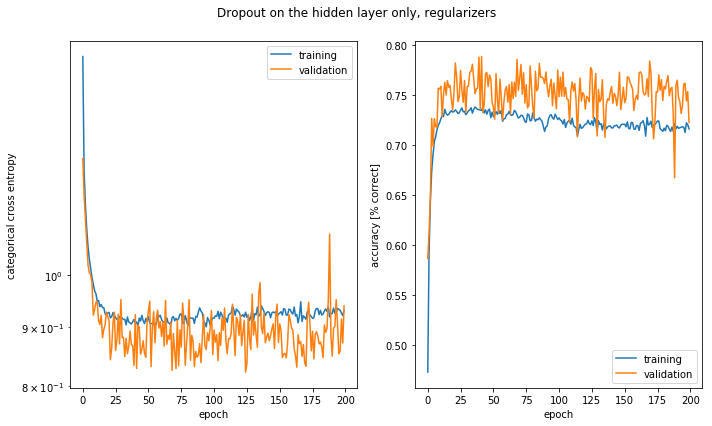

In [29]:
from keras import regularizers
#Dropout on the hidden layer only, regularizers
model1_dropout4 = Sequential()
model1_dropout4.add(Dense(200, activation='relu', input_shape=(256,), kernel_regularizer=regularizers.l2(0.01), 
                         bias_regularizer=regularizers.l2(0.01)))
model1_dropout4.add(Dropout(0.2))
model1_dropout4.add(Dense(5, activation='softmax'))
model1_dropout4.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history_model1_dropout4 = model1_dropout4.fit(x_train, y_train, epochs=200, verbose=1, validation_data=(x_test, y_test))
print(model1_dropout4.evaluate(x_test, y_test))
plot_history(history_model1_dropout4, title="Dropout on the hidden layer only, regularizers")

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

In [10]:
#First we have to reshape the whole dataset
if keras.backend.image_data_format() == 'channels_first':
    x_train_cnn = x_train.reshape((x_train.shape[0], 1, 16, 16))
    x_test_cnn = x_test.reshape((x_test.shape[0], 1, 16, 16))
    input_shape = (1,16,16)
elif keras.backend.image_data_format() == 'channels_last':
    x_train_cnn = x_train.reshape((x_train.shape[0], 16, 16, 1))
    x_test_cnn = x_test.reshape((x_test.shape[0], 16, 16, 1))
    input_shape = (16,16,1)

In [11]:
print(x_train_cnn.shape)

(40427, 16, 16, 1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               200832    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 201,797
Trainable params: 201,797
Non-trainable params: 0
_________________________________________________________________
(0.26676246864528247, 0.9268144753247759)


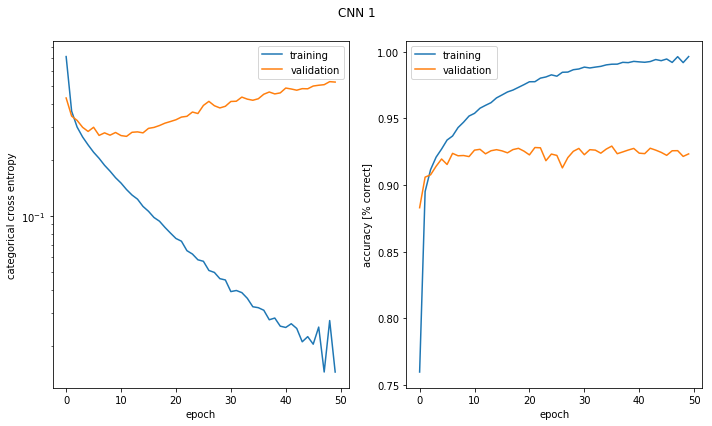

In [95]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_cnn1 = fit_model(model, x_train_cnn, y_train, epochs=50, verbose=1, validation_data=(x_test_cnn, y_test))
score_cnn1 = scoreEarlyStopping(history_cnn1)
print(score_cnn1)
plot_history(history_cnn1, title="CNN 1")
model_cnn1 = model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               200832    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total para

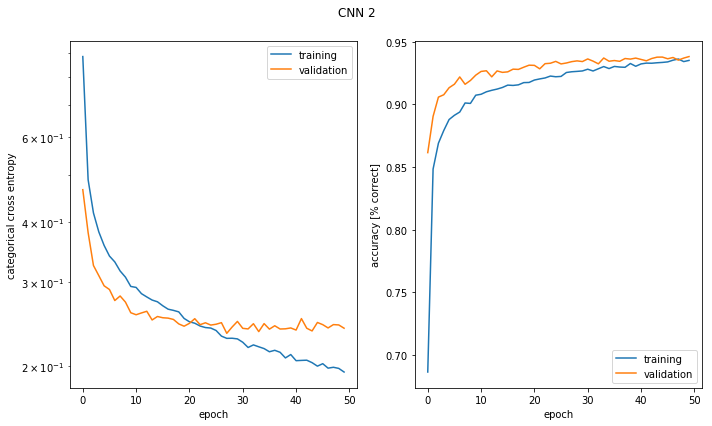

In [13]:
#adding some dropout
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_cnn2 = fit_model(model, x_train_cnn, y_train, epochs=50, verbose=1, validation_data=(x_test_cnn, y_test))
score_cnn2 = scoreEarlyStopping(history_cnn2)
print(score_cnn2)
plot_history(history_cnn2, title="CNN 2")
model_cnn2 = model

In [ ]:
#Another convolution
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_cnn3 = fit_model(model, x_train_cnn, y_train, epochs=50, verbose=1, validation_data=(x_test_cnn, y_test))
score_cnn3 = scoreEarlyStopping(history_cnn3)
print(score_cnn3)
plot_history(history_cnn3, title="CNN 2")
model_cnn2 = model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 645       
Total para